In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
findspark.init()

In [ ]:
!pip install pyspark
!wget -q -O ngrok.zip https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok.zip
!pip install pyngrok

Archive:  ngrok.zip
  inflating: ngrok                   


In [ ]:
!ngrok config add-authtoken 2mjNc2jTdyIgjTg5q98vIRQyLen_5cpj3KWZcuHz4KG32bbTx

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Kill all running ngrok processes
ngrok.kill()

print("ngrok process has been killed.")

ngrok process has been killed.


In [ ]:
import os
from pyspark.sql import SparkSession
from pyngrok import ngrok

# Specify the event log directory within Colab's temporary storage
event_log_dir = "/content/spark-event-log"

# Create the directory if it doesn't exist
os.makedirs(event_log_dir, exist_ok=True)

# Initialize SparkSession with event logging enabled
spark = SparkSession.builder \
    .appName("Hotel Prediction") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "16") \
    .config("spark.driver.memory", "16g") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", event_log_dir) \
    .config("spark.ui.port", "4050") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .getOrCreate()

# Kill any existing ngrok processes to avoid session conflicts
ngrok.kill()

# Expose the Spark Web UI using ngrok
spark_ui_tunnel = ngrok.connect(addr="4050")
print(f"Access the Spark Web UI at: {spark_ui_tunnel.public_url}")

# Verify the Spark context
print("SparkSession created successfully!")

Access the Spark Web UI at: https://5fb3-34-168-224-100.ngrok-free.app
SparkSession created successfully!


In [ ]:
hotel_df = spark.read.csv(
    'hotel_dataset.csv',
    header=True,
    inferSchema=True
)

In [ ]:
hotel_df.printSchema()

# Print Dataframe
hotel_df.show()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [ ]:
# Number of rows
num_rows = hotel_df.count()

# Number of columns
num_columns = len(hotel_df.columns)

# Print dimensions
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 119390
Number of columns: 32


DATA CLEANING

In [ ]:
hotel_df.dtypes # Getting the datatypes for each column

[('hotel', 'string'),
 ('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'int'),
 ('arrival_date_month', 'string'),
 ('arrival_date_week_number', 'int'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'string'),
 ('babies', 'int'),
 ('meal', 'string'),
 ('country', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('agent', 'string'),
 ('company', 'string'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string'),
 ('reservation_status_date', 'string')]

In [ ]:
hotel_df.describe().show() # Descriptive analysis for each column

+-------+------------+-------------------+------------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+------------------+------------------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+-----------------------+
|summary|       hotel|        is_canceled|         lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|pr

In [ ]:
hotel_df.summary().show()#Statistical analysis for each column

+-------+------------+-------------------+------------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+------------------+------------------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+-----------------------+
|summary|       hotel|        is_canceled|         lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|pr

In [ ]:
from pyspark.sql.functions import col, sum, when

# Count missing values, including standard NULLs, empty strings, and common placeholders
hotel_df.select([
    sum(when(col(c).isNull() | (col(c) == "") | col(c).isin("NA", "NULL", "N/A"), 1).otherwise(0)).alias(c)
    for c in hotel_df.columns
]).show()

+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_reque

In [ ]:
# Replace 'attribute_name' with the column name you want unique values for
unique_values = hotel_df.select("country").distinct().count()

# Show unique values
print(unique_values)

178


Step 1: Dropping Columns

In [ ]:
# Remove multiple columns from dataset
hotel_df = hotel_df.drop("agent", "company")
# Show the DataFrame after removing the column
print(len(hotel_df.columns))

30


Step 2 : Removing Duplicate values

In [ ]:
# Remove duplicates
hotel_df  = hotel_df.dropDuplicates()

# Show the count of DataFrame rows  after removing duplicates
print(hotel_df.count())

87370


Step 3: Removing Inconsistent Rows i.e., Missing values

In [ ]:
# Replace "NA" with null in both 'children' and 'country' columns
hotel_df = hotel_df.withColumn("children",
                             when(col("children") == "NA", None).otherwise(col("children"))) \
                 .withColumn("country",
                             when(col("country") == "NULL", None).otherwise(col("country")))

# Drop rows with null 'children' or 'country'
hotel_df = hotel_df.dropna(subset=["children", "country"])

# Show the count of DataFrame rows  after removing inconsistent rows
print(hotel_df.count())

86914


In [ ]:
from pyspark.sql.functions import col, sum, when

# Count missing values, including standard NULLs, empty strings, and common placeholders
hotel_df.select([
    sum(when(col(c).isNull() | (col(c) == "") | col(c).isin("NA", "NULL", "N/A"), 1).otherwise(0)).alias(c)
    for c in hotel_df.columns
]).show()

+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_requests|reservation_status|reser

Step 4: Combining 2 Columns into 1

In [ ]:
# Creating a new column 'kids' by summing the values of 'babies' and 'children' columns
hotel_df = hotel_df.withColumn("kids", col("babies") + col("children").cast("int"))

# Drop the original columns 'FirstName' and 'LastName'
hotel_df = hotel_df.drop("babies", "children")

# Show the DataFrame with the combined column
hotel_df.show()

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requests|reservation_status|reservatio

Step 5 : Outlier Detection

In [ ]:
from pyspark.sql import functions as F

# Calculate mean and standard deviation of the column
mean = hotel_df.select(F.mean("adr")).collect()[0][0]
stddev = hotel_df.select(F.stddev("adr")).collect()[0][0]

# Calculate Z-Score and identify outliers
threshold = 3  # Define the threshold for Z-score

hotel_df = hotel_df.withColumn("z_score", (F.col("adr") - mean) / stddev)

# Filter out rows where the Z-score is above the threshold
hotel_df = hotel_df.filter(F.abs(F.col("z_score")) <= threshold)

# Drop the 'z_score' column as it's no longer needed
hotel_df = hotel_df.drop("z_score")

# Show the DataFrame after removing outliers
hotel_df.show()

print(hotel_df.count())

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requests|reservation_status|reservatio

Step 6 : Adding New Season Column

In [ ]:
# Define a mapping of month names to their corresponding seasons
month_to_season = {
    "January": "Winter", "February": "Winter", "March": "Spring", "April": "Spring", "May": "Spring",
    "June": "Summer", "July": "Summer", "August": "Summer", "September": "Fall", "October": "Fall",
    "November": "Fall", "December": "Winter"
}

# Create a case expression to map month names to seasons
hotel_df = hotel_df.withColumn(
    "season",
    F.when(F.col("arrival_date_month") == "January", "Winter")
     .when(F.col("arrival_date_month") == "February", "Winter")
     .when(F.col("arrival_date_month") == "March", "Spring")
     .when(F.col("arrival_date_month") == "April", "Spring")
     .when(F.col("arrival_date_month") == "May", "Spring")
     .when(F.col("arrival_date_month") == "June", "Summer")
     .when(F.col("arrival_date_month") == "July", "Summer")
     .when(F.col("arrival_date_month") == "August", "Summer")
     .when(F.col("arrival_date_month") == "September", "Fall")
     .when(F.col("arrival_date_month") == "October", "Fall")
     .when(F.col("arrival_date_month") == "November", "Fall")
     .otherwise("Winter")  # For December or any unexpected month name
)

# Show the DataFrame with the new 'season' column
hotel_df.show()

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requests|reservation_status|res

Step 7 : Feature Engineering

In [ ]:
# Assuming 'reservation_status_date' is in the format "dd/MM/yyyy"
# Split the date string by "/"
hotel_df = hotel_df.withColumn(
    "res_day", F.split(F.col("reservation_status_date"), "/").getItem(0)
).withColumn(
    "res_month", F.split(F.col("reservation_status_date"), "/").getItem(1)
).withColumn(
    "res_year", F.split(F.col("reservation_status_date"), "/").getItem(2)
)

# Replace year '15' with '2015' in the 'year' column
# Replace '16' with '2016' and '17' with '2017' in the 'year' column
hotel_df = hotel_df.withColumn(
    "res_year",
    F.when(F.col("res_year") == "15", "2015")
    .when(F.col("res_year") == "16", "2016")
    .when(F.col("res_year") == "17", "2017")
    .otherwise(F.col("res_year"))
)

# Show the updated DataFrame with the new columns
hotel_df.show()

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+-----+---------------------------+-------------------------+------------------+-----------------------+----+------+-------+---------+--------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|  adr|required_car_parking_spaces|total_of_special_requ

In [ ]:
# Show the updated DataFrame with the new 'Reservation_status_date' column in date format
hotel_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: s

In [ ]:
# List of columns to be removed
columns_to_remove = ["reservation_status_date"]

# Drop the columns from the DataFrame
hotel_df = hotel_df.drop(*columns_to_remove)

# Show the DataFrame after removing the columns
hotel_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: s

In [ ]:
# List of columns to be removed
columns_to_remove = ["country"]

# Drop the columns from the DataFrame
hotel_df = hotel_df.drop(*columns_to_remove)

# Show the DataFrame after removing the columns
hotel_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: string (nullable = true)
 |-- days_in_wa

DATA PREPROCESSING

In [ ]:
hotel_df = hotel_df.withColumn("arrival_date_year", hotel_df["arrival_date_year"].cast("string"))

In [ ]:
hotel_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: string (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: string (nullable = true)
 |-- days_in_wai

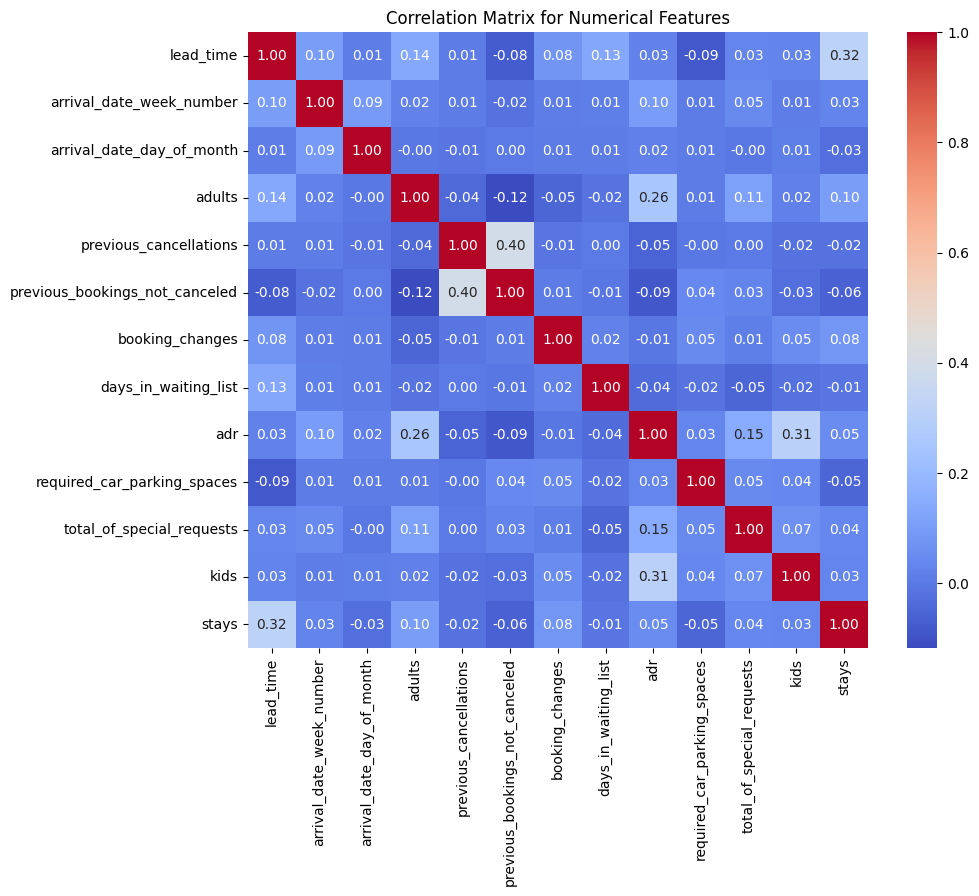

Top Features by Importance:
hotel_ohe: 0.004226944268235905
arrival_date_month_ohe: 0.0010670295007017677
arrival_date_year_ohe: 0.0007757236076771717
customer_type_ohe: 0.0002811656188735154
market_segment_ohe: 0.00026024190093352465
reserved_room_type_ohe: 8.943206903043712e-05
distribution_channel_ohe: 6.999679233259825e-05
season_ohe: 3.911798041466776e-05
deposit_type_ohe: 1.1193106562622254e-05
meal_ohe: 0.0


<ipython-input-28-9fd63159c9b9>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


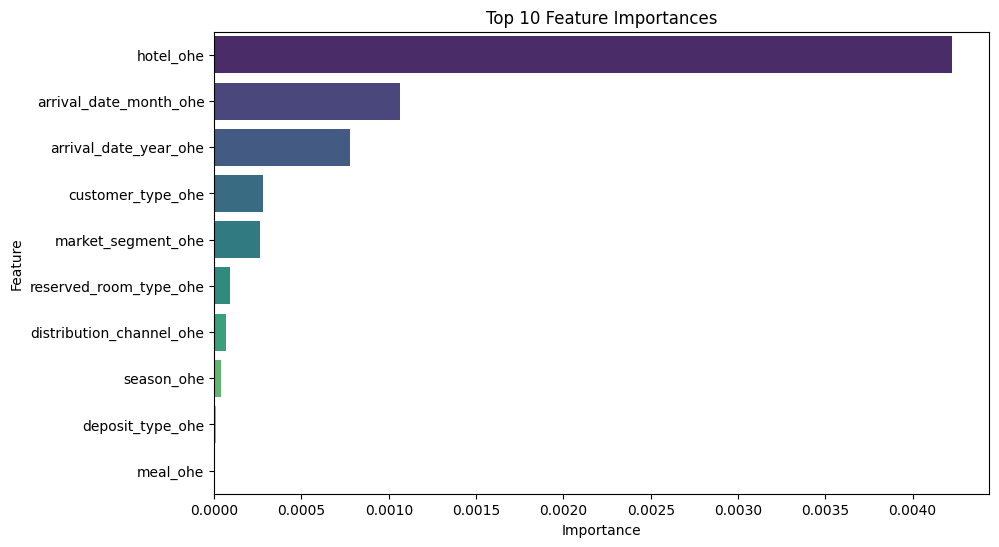

In [ ]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, MinMaxScaler, VectorAssembler, ChiSqSelector
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define Columns
numerical_columns = [
    "lead_time", "arrival_date_week_number", "arrival_date_day_of_month",
    "stays_in_weekend_nights", "stays_in_week_nights", "adults",
    "previous_cancellations", "previous_bookings_not_canceled",
    "booking_changes", "days_in_waiting_list", "adr",
    "required_car_parking_spaces", "total_of_special_requests", "kids"
]

categorical_columns = [
    "hotel", "arrival_date_year", "arrival_date_month", "meal",
    "market_segment", "distribution_channel", "reserved_room_type",
    "assigned_room_type", "deposit_type", "customer_type", "season"
]

# Combine stays for simplicity
hotel_df = hotel_df.withColumn("stays", col("stays_in_weekend_nights") + col("stays_in_week_nights"))
numerical_columns = [col for col in numerical_columns if col not in ["stays_in_weekend_nights", "stays_in_week_nights"]]
numerical_columns.append("stays")

# Step 1: StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Step 2: OneHotEncoder for indexed categorical columns
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_ohe") for col in categorical_columns]

# Step 3: Assemble numerical features
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")

# Step 4: Min-Max Scaling for numerical features
scaler = MinMaxScaler(inputCol="numerical_features", outputCol="scaled_features")

# Step 5: Assemble all features (categorical + scaled numerical)
all_features = [col + "_ohe" for col in categorical_columns] + ["scaled_features"]
final_assembler = VectorAssembler(inputCols=all_features, outputCol="features")

# Step 6: Chi-Square Selector for feature selection
chi_selector = ChiSqSelector(featuresCol="features", outputCol="selected_features", labelCol="is_canceled")

# Step 7: Define the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, final_assembler, chi_selector])

# Fit and transform the data
processed_df = pipeline.fit(hotel_df).transform(hotel_df)

# Select the final dataset with selected features and target
final_df = processed_df.select("selected_features", "is_canceled")

# Correlation Analysis for Numerical Features
numerical_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_vector")
numerical_df = numerical_assembler.transform(hotel_df)
correlation_matrix = Correlation.corr(numerical_df, "numerical_vector").head()[0].toArray()

# Convert correlation matrix to Pandas DataFrame for visualization
correlation_df = pd.DataFrame(
    correlation_matrix,
    columns=numerical_columns,
    index=numerical_columns
)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

# Feature Importance from Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="is_canceled")
rf_model = rf.fit(processed_df)

# Get feature importances
feature_importances = rf_model.featureImportances
important_features = sorted(zip(all_features, feature_importances), key=lambda x: x[1], reverse=True)

# Display top features
print("Top Features by Importance:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")

# Plot feature importance
feature_names, importances = zip(*important_features[:10])
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Split the data into training and testing sets
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

# Define the models
models = {
    "Logistic Regression": LogisticRegression(featuresCol="selected_features", labelCol="is_canceled"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="selected_features", labelCol="is_canceled"),
    "Random Forest": RandomForestClassifier(featuresCol="selected_features", labelCol="is_canceled"),
    "SVM": LinearSVC(featuresCol="selected_features", labelCol="is_canceled")
}

# Define the evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="is_canceled", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_canceled", predictionCol="prediction", metricName="f1")



--- Training Logistic Regression ---

Confusion Matrix:
True Positive (TP): 1999
True Negative (TN): 11348
False Positive (FP): 865
False Negative (FN): 2757
Logistic Regression Results:
  Accuracy: 0.7866
  F1 Score: 0.7677
  Precision: 0.6980
  Recall: 0.4203
  Sensitivity: 0.4203
  Specificity: 0.9292

--- Training Decision Tree ---

Confusion Matrix:
True Positive (TP): 2013
True Negative (TN): 11315
False Positive (FP): 898
False Negative (FN): 2743
Decision Tree Results:
  Accuracy: 0.7854
  F1 Score: 0.7671
  Precision: 0.6915
  Recall: 0.4233
  Sensitivity: 0.4233
  Specificity: 0.9265

--- Training Random Forest ---

Confusion Matrix:
True Positive (TP): 273
True Negative (TN): 12210
False Positive (FP): 3
False Negative (FN): 4483
Random Forest Results:
  Accuracy: 0.7356
  F1 Score: 0.6384
  Precision: 0.9891
  Recall: 0.0574
  Sensitivity: 0.0574
  Specificity: 0.9998

--- Training SVM ---

Confusion Matrix:
True Positive (TP): 1354
True Negative (TN): 11798
False Positive

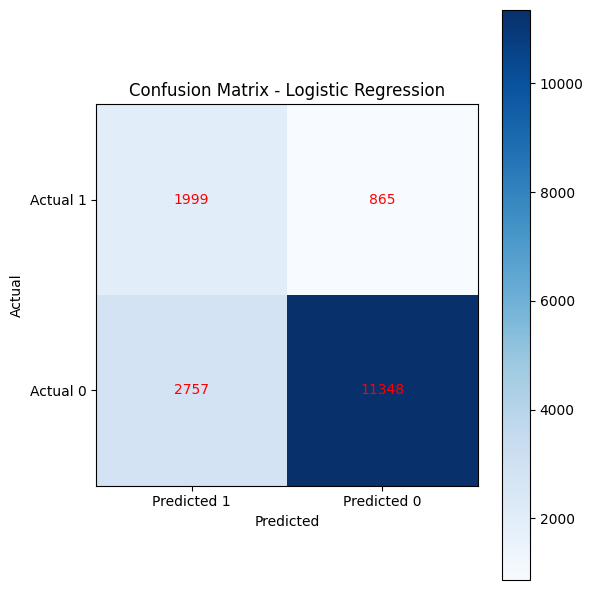

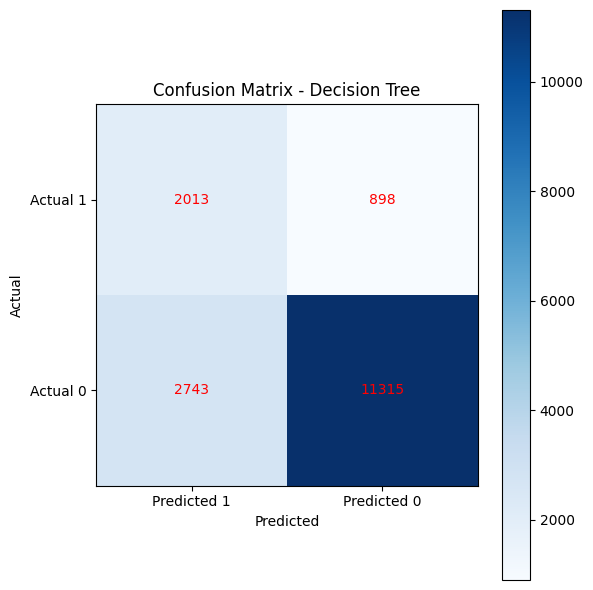

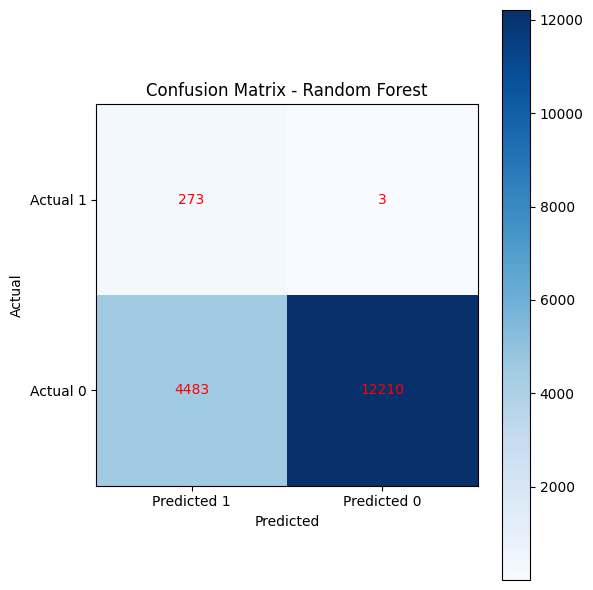

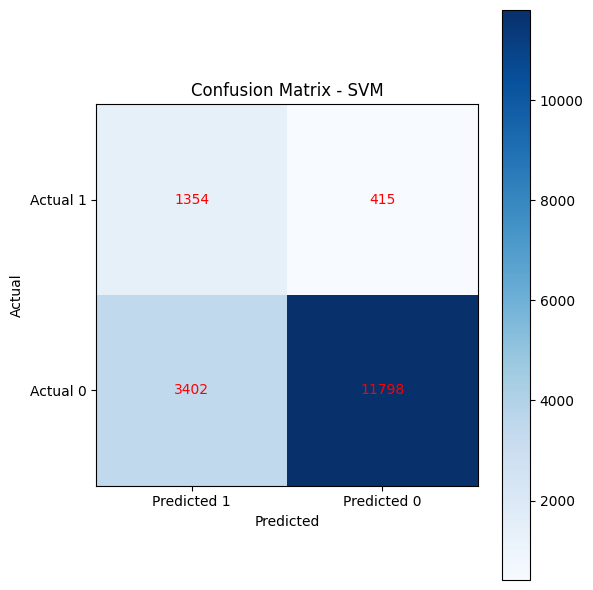

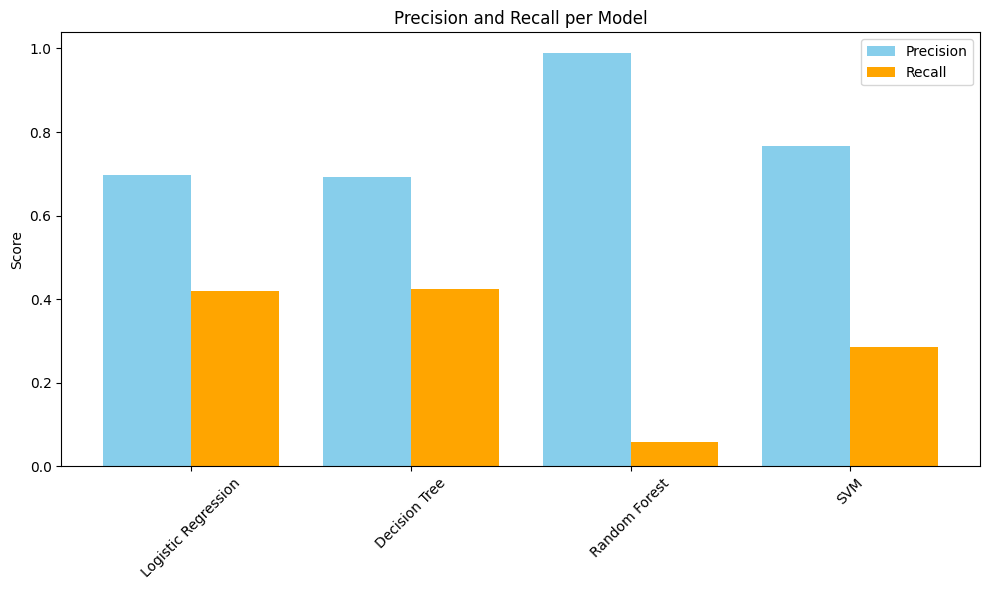

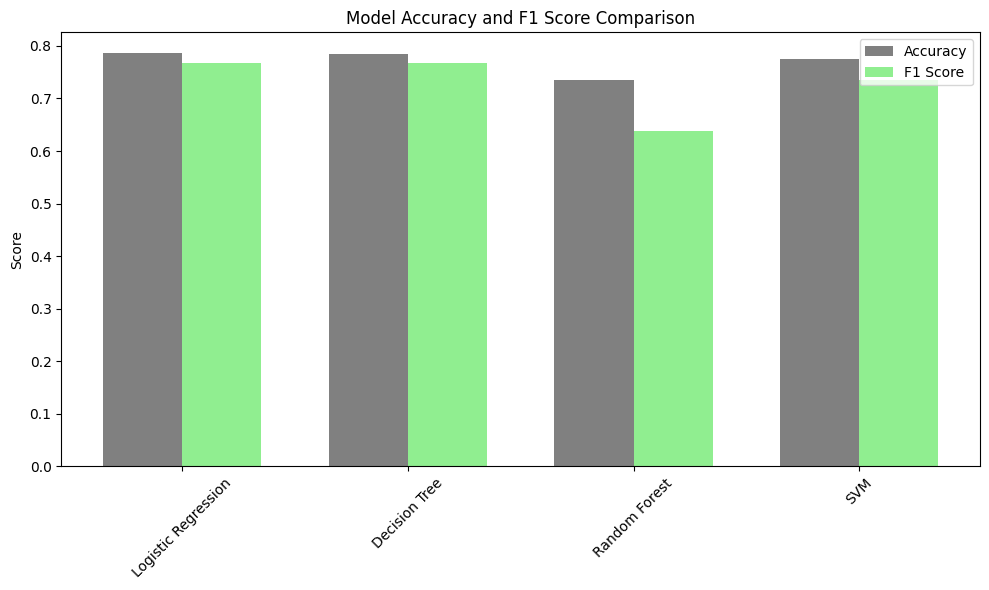

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Initialize the dictionary to store metrics
metrics = []

# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Train the model
    trained_model = model.fit(train_df)

    # Make predictions
    predictions = trained_model.transform(test_df)

    # Evaluate performance metrics
    accuracy = evaluator_accuracy.evaluate(predictions)
    f1_score = evaluator_f1.evaluate(predictions)

    # Compute confusion matrix components
    tp = predictions.filter((predictions.is_canceled == 1) & (predictions.prediction == 1)).count()
    tn = predictions.filter((predictions.is_canceled == 0) & (predictions.prediction == 0)).count()
    fp = predictions.filter((predictions.is_canceled == 0) & (predictions.prediction == 1)).count()
    fn = predictions.filter((predictions.is_canceled == 1) & (predictions.prediction == 0)).count()

    # Compute additional metrics with safeguards against division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    sensitivity = recall  # Sensitivity is the same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(f"True Positive (TP): {tp}")
    print(f"True Negative (TN): {tn}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")

    # Save metrics
    metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1_score,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

    # Print evaluation metrics
    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1_score:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Sensitivity: {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")

# Visualize metrics
df_metrics = pd.DataFrame(metrics)

# Confusion Matrix Graphs
for metric in metrics:
    model_name = metric["Model"]
    confusion_matrix = np.array([[metric["TP"], metric["FP"]],
                                  [metric["FN"], metric["TN"]]])

    plt.figure(figsize=(6, 6))
    plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    plt.xticks([0, 1], ['Predicted 1', 'Predicted 0'])
    plt.yticks([0, 1], ['Actual 1', 'Actual 0'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Annotate confusion matrix
    for i in range(2):
        for j in range(2):
            plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='red')

    plt.tight_layout()
    plt.show()

# Precision-Recall Visualization with Consistent Colors
plt.figure(figsize=(10, 6))
x = np.arange(len(df_metrics['Model']))
width = 0.4

# Define consistent colors for precision and recall
precision_color = 'skyblue'
recall_color = 'orange'

plt.bar(x - width/2, df_metrics['Precision'], width, color=precision_color, label='Precision')
plt.bar(x + width/2, df_metrics['Recall'], width, color=recall_color, label='Recall')

plt.xticks(x, df_metrics['Model'], rotation=45)
plt.title('Precision and Recall per Model')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

# Model Comparison (Accuracy & F1 Score)
plt.figure(figsize=(10, 6))
x = np.arange(len(df_metrics['Model']))
width = 0.35

plt.bar(x - width/2, df_metrics['Accuracy'], width, label='Accuracy', color='gray')
plt.bar(x + width/2, df_metrics['F1 Score'], width, label='F1 Score', color='lightgreen')

plt.xticks(x, df_metrics['Model'], rotation=45)
plt.title('Model Accuracy and F1 Score Comparison')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()
